**Predicting IDC in Breast Cancer Histology Images** 

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

The goal of this script is to identify IDC when it is present in otherwise unlabeled histopathology images. The dataset consists of 277,524 50x50 pixel RGB digital image patches that were derived from 162 H&E-stained breast histopathology samples. These images are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma. For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

*Step 1: Import Modules*

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import cv2
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


*Step 2: Explore Data*

In [2]:
imagePatches = glob('/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png
/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2251_y751_class0.png
/Users/ptm/desktop/T

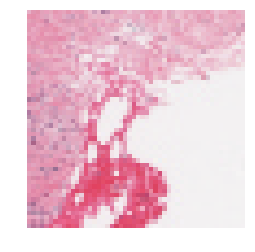

In [3]:
image_name = "/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

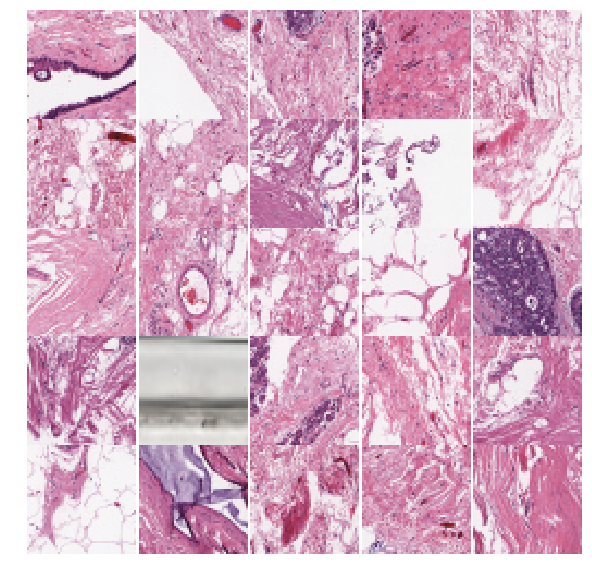

In [4]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

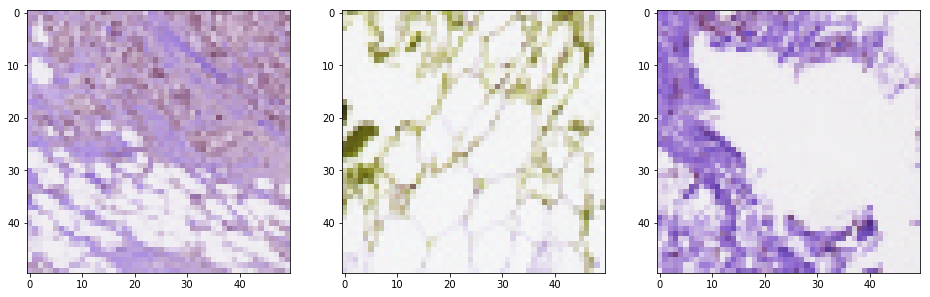

In [5]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

*Step 3: Preprocess Data*

In [6]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png', '/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png', '/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png', '/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png', '/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png'] 

IDC(+)

 ['/Users/ptm/desktop/Three_Portable_Data_Science_Projects/Predict_IDC_in_Breast_Cancer_Histology_Images/IDC_regular_ps50_idx5/9036/1/9036_idx5_x185

In [7]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [8]:
X,Y = proc_images(0,100000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 100000
Number of IDC(-) Images: 74957
Number of IDC(+) Images: 25043
Percentage of positive images: 25.04%
Image shape (Width, Height, Channels): (50, 50, 3)


In [10]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[212, 193, 229], [223, 202, 233], [202, 184,...       0
1  [[[198, 167, 209], [197, 169, 218], [211, 191,...       0
2  [[[232, 222, 236], [181, 143, 207], [193, 171,...       0
3  [[[153, 110, 143], [142, 103, 163], [169, 139,...       0
4  [[[195, 169, 226], [200, 175, 220], [209, 188,...       0
5  [[[98, 74, 167], [234, 226, 240], [224, 215, 2...       0
6  [[[236, 231, 242], [242, 239, 243], [244, 237,...       0
7  [[[221, 205, 224], [239, 235, 244], [240, 239,...       0
8  [[[222, 207, 229], [226, 211, 230], [236, 225,...       0
9  [[[242, 239, 244], [241, 237, 244], [239, 235,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


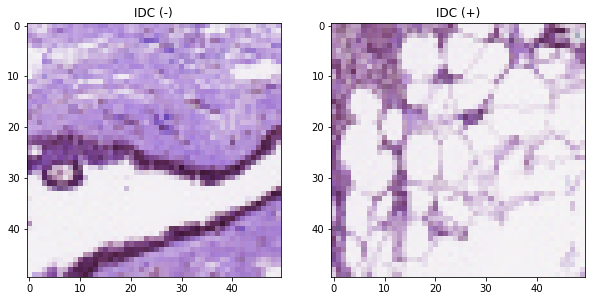

In [11]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

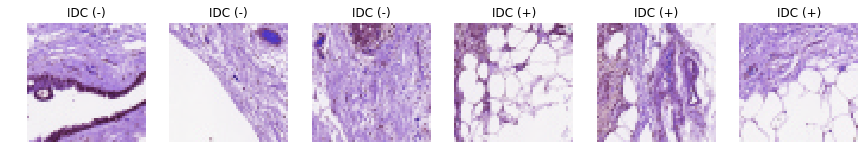

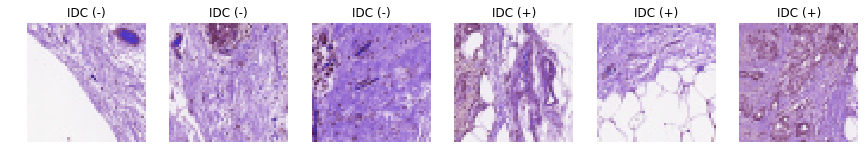

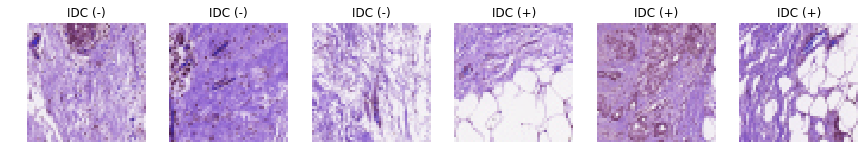

In [12]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1. This will make the data compatible with a wide variety of different classification algorithms.

We also want to set aside 20% of the data for k-fold cross-validation testing. This will make the trained model less prone to overfitting.

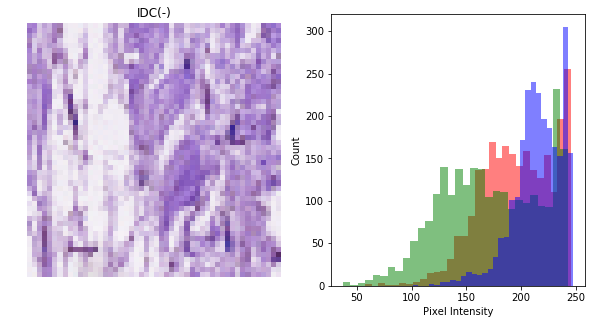

In [13]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [14]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (80000, 50, 50, 3)
Testing Data Shape: (20000, 50, 50, 3)


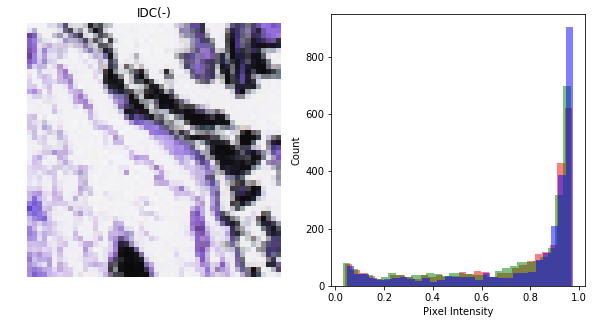

In [15]:
plotHistogram(X_train[100])

In [16]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

*Step 4: Define Helper Functions for the Classification Task*

In [17]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print(class_weight)

[ 0.66641121  2.00230265]


In [18]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

*Step 5: Run Classification Algorithm*

In a previous kernel I evaluated a number of different classification algorithms while using an abbreviated form of this same dataset.  To see how and why I chose the model that I use below, please see the following link: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/

Epoch 1/3
2500/2500 [==============================] - 2022s - loss: 0.3519 - acc: 0.8505 - val_loss: 0.3275 - val_acc: 0.8585
Epoch 3/3
2500/2500 [==============================] - 1522s - loss: 0.3359 - acc: 0.8580 - val_loss: 0.3179 - val_acc: 0.8665

Keras CNN #1C - accuracy: 0.86645 


             precision    recall  f1-score   support

     IDC(-)       0.91      0.92      0.91     14934
     IDC(+)       0.75      0.72      0.73      5066

avg / total       0.86      0.87      0.87     20000



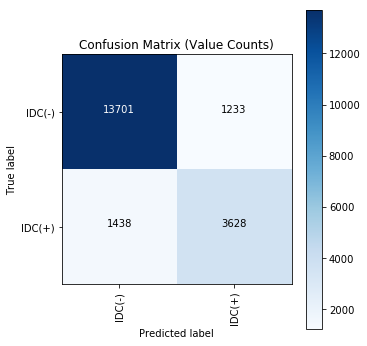

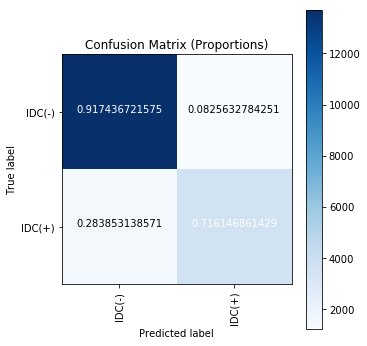

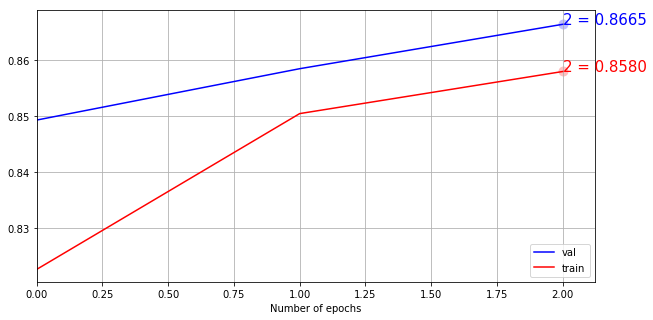

In [ ]:
def runKerasCNNAugment(a,b,c,d):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 3
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=class_weight, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()),title='Confusion Matrix (Value Counts)') 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()),normalize=True,title='Confusion Matrix (Proportions)') 
runKerasCNNAugment(X_train, Y_trainHot,  X_test, Y_testHot)
plotKerasLearningCurve()

This looks pretty good!  And it does not look too be to overfit or too biased based off of the learning curve and confusion matrix.  In the future, I will improve the score by optimizing the data augmentation step as well as the network architecture.

The End

To Do:
1) Optimize data augmentation
2) Optimize NN architecture